<h2> 6. Bayes Classification </h2>

This notebook has the code for the charts in Chapter 6

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datalab.bigquery as bq

In [57]:
sql = """
SELECT DISTANCE, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001 AND dep_delay > -20 AND dep_delay < 30 AND distance < 2000
"""
df = bq.Query(sql).to_dataframe(dialect='standard')

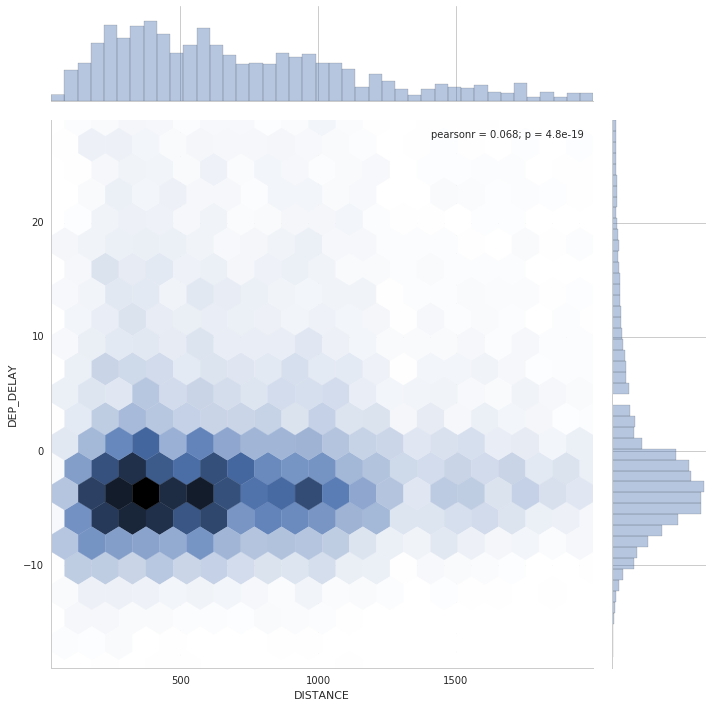

In [58]:
sns.set_style("whitegrid")
g = sns.jointplot(df['DISTANCE'], df['DEP_DELAY'], kind="hex", size=10, joint_kws={'gridsize':20})